# Geospatial Visualisation

In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx


import sys, os
sys.path.append(os.path.abspath('../'))
from scripts.utils import create_dir, get_runtime
import time
start_time = time.time()

In [9]:
# load sa2 shapefile
sa2_gdf = gpd.read_file('../data/landing/sa2/sa2-21-shp/')
sa2_gdf['sa2_code'] = sa2_gdf['SA2_CODE21']
sa2_gdf = sa2_gdf[['sa2_code', 'geometry']]
sa2_gdf

,sa2_code,geometry
0,101021007,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,"POLYGON ((149.21899 -35.36738, 149.218 -35.366..."
2,101021009,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,"POLYGON ((149.19572 -35.36126, 149.1997 -35.35..."
...,...,...
2468,901031003,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,None
2471,999999499,None


In [19]:
# load rental history/current dataset 2017 - 2024
rental_df = pd.read_csv('../data/curated/rental-17-24.csv')
rental_df = rental_df[
    ['sa2_code', 'suburb', 'bed', 'bath', 'car', 'type', 'year', 'median_income', 'population', 'time_city', 'avg_property_price', 'rented_price']
]
rental_df['sa2_code'] = rental_df['sa2_code'].astype('Int64').astype(str)
rental_df = rental_df.merge(sa2_gdf, on='sa2_code',how='left')

rental_df

,sa2_code,suburb,bed,bath,car,type,year,median_income,population,time_city,avg_property_price,rented_price,geometry
0,206041505,MELBOURNE,2.0,2.0,1.0,Unit/apmt,2023,44492.400500,20027.0,263.3,682488.770000,800,"POLYGON ((144.9528 -37.8161, 144.95235 -37.815..."
1,206041505,MELBOURNE,2.0,2.0,1.0,Unit/apmt,2023,44492.400500,20027.0,263.3,682488.770000,800,"POLYGON ((144.9528 -37.8161, 144.95235 -37.815..."
2,206041505,MELBOURNE,2.0,2.0,1.0,Unit/apmt,2021,39300.000000,16098.0,263.3,619543.745192,540,"POLYGON ((144.9528 -37.8161, 144.95235 -37.815..."
3,206041505,MELBOURNE,2.0,1.0,0.0,Unit/apmt,2023,44492.400500,20027.0,263.3,682488.770000,720,"POLYGON ((144.9528 -37.8161, 144.95235 -37.815..."
4,206041505,MELBOURNE,2.0,1.0,0.0,Unit/apmt,2023,44492.400500,20027.0,263.3,682488.770000,650,"POLYGON ((144.9528 -37.8161, 144.95235 -37.815..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409722,212011552,PAKENHAM,3.0,1.0,0.0,House,2024,55683.420715,28466.0,3251.4,843219.858156,520,"POLYGON ((145.43721 -38.0642, 145.43739 -38.06..."
1409723,212011551,PAKENHAM,3.0,2.0,2.0,House,2024,57772.670788,7044.0,3126.4,843219.858156,500,"POLYGON ((145.48648 -38.07189, 145.48751 -38.0..."
1409724,212011551,PAKENHAM,3.0,2.0,2.0,House,2024,57772.670788,7044.0,3126.4,843219.858156,500,"POLYGON ((145.48648 -38.07189, 145.48751 -38.0..."
1409725,212011550,PAKENHAM,4.0,2.0,2.0,Unit/apmt,2024,58924.808098,9820.0,3297.1,843219.858156,580,"POLYGON ((145.42363 -38.06459, 145.42295 -38.0..."


In [21]:
house_df = rental_df[rental_df['type'] == 'House']
unit_df = rental_df[rental_df['type'] == 'Unit/apmt']
print('House:', house_df.shape)
print('Unit:', unit_df.shape)

In [22]:
house_agg_df = house_df.groupby(['sa2_code', 'geometry']).agg({
    'median_income': 'mean',
    'population': 'mean',
    'time_city': 'mean',
    'avg_property_price': 'mean',
    'rented_price': 'mean',
}).reset_index()
house_agg_df

,sa2_code,geometry,median_income,population,time_city,avg_property_price,rented_price
0,201011001,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5...",56951.460630,16257.494832,731.215504,570826.827030,423.953488
1,201011002,"POLYGON ((143.81896 -37.55582, 143.81644 -37.5...",54103.952297,12156.185198,227.001394,582949.696431,373.100107
2,201011005,"POLYGON ((143.84171 -37.61596, 143.84176 -37.6...",53618.192684,7359.720524,1032.851528,613318.227983,424.803493
3,201011006,"POLYGON ((143.7505 -37.59119, 143.75044 -37.59...",52539.217610,10410.098079,585.678868,494287.385296,392.483316
4,201011007,"POLYGON ((143.73296 -37.62333, 143.73263 -37.6...",56090.000506,4134.875000,1290.141667,763879.874776,450.000000
...,...,...,...,...,...,...,...
503,217031476,"MULTIPOLYGON (((143.40263 -38.78152, 143.40252...",36257.616181,3792.944444,5590.558333,639150.339412,318.888889
504,217041477,"POLYGON ((142.41438 -38.09303, 142.414 -38.072...",48013.771840,6924.673913,6690.415942,395219.509997,389.764493
505,217041478,"MULTIPOLYGON (((142.0087 -38.41715, 142.00876 ...",48026.980876,9886.387156,8836.456330,637564.837578,422.484404
506,217041479,"POLYGON ((142.43668 -38.35544, 142.43658 -38.3...",50052.135903,22287.392934,8020.587203,476362.443677,403.218097


In [38]:
unit_agg_df = unit_df.groupby(['sa2_code', 'geometry']).agg({
    'median_income': 'mean',
    'population': 'mean',
    'time_city': 'mean',
    'avg_property_price': 'mean',
    'rented_price': 'mean',
}).reset_index()
unit_agg_df

,sa2_code,geometry,median_income,population,time_city,avg_property_price,rented_price
0,201011001,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5...",58622.297437,17166.633252,738.930073,680606.712955,429.613692
1,201011002,"POLYGON ((143.81896 -37.55582, 143.81644 -37.5...",55090.493235,12103.465268,205.513495,624015.175838,345.759768
2,201011005,"POLYGON ((143.84171 -37.61596, 143.84176 -37.6...",54244.934251,7345.794118,1025.583529,660124.996267,344.500000
3,201011006,"POLYGON ((143.7505 -37.59119, 143.75044 -37.59...",53300.506352,10838.871166,573.905112,530807.006184,368.503067
4,201011007,"POLYGON ((143.73296 -37.62333, 143.73263 -37.6...",58351.745910,4144.888889,1103.666667,700078.306878,491.111111
...,...,...,...,...,...,...,...
503,217031476,"MULTIPOLYGON (((143.40263 -38.78152, 143.40252...",39081.520105,3837.764706,5816.388235,571689.512807,295.000000
504,217041477,"POLYGON ((142.41438 -38.09303, 142.414 -38.072...",49119.245423,6980.027523,6186.653211,654030.354201,359.321101
505,217041478,"MULTIPOLYGON (((142.0087 -38.41715, 142.00876 ...",50628.802583,9963.223404,8863.047163,715850.849683,390.212766
506,217041479,"POLYGON ((142.43668 -38.35544, 142.43658 -38.3...",50131.724205,22291.248187,8015.660123,483313.831802,332.802566


In [51]:
# Function to plot heatmaps for different columns
def plot_geospatial_heatmap_osm_save(gdf, column, title, cmap, property_type):
    """ Plot a heatmap of a given column in a GeoDataFrame with OpenStreetMap as background.
    """    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the Victoria SA2 boundaries with heatmap and a custom color scheme
    gdf.plot(column=column, ax=ax, legend=True, cmap=cmap, alpha=0.7,
             legend_kwds={'shrink': 0.5, 'label': f"{title} (Scale)"})  # Adjust legend size and label
    
    # Add OpenStreetMap as background
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    
    # Title and labels
    ax.set_title(f'{property_type} {title}', fontsize=18, fontweight='bold', pad=20)
    ax.set_axis_off()
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(f"../plots/{property_type.lower()}_{column}.png", dpi=300)  # Save the figure with high resolution
    plt.show()

# List of columns and corresponding color maps to plot
columns_to_plot = {
    'median_income': 'OrRd',            # Orange-Red color scheme for income
    'population': 'Blues',              # Blue color scheme for population
    'avg_property_price': 'Greens',     # Green color scheme for property price
    'rented_price': 'Purples'           # Purple color scheme for rented price
}

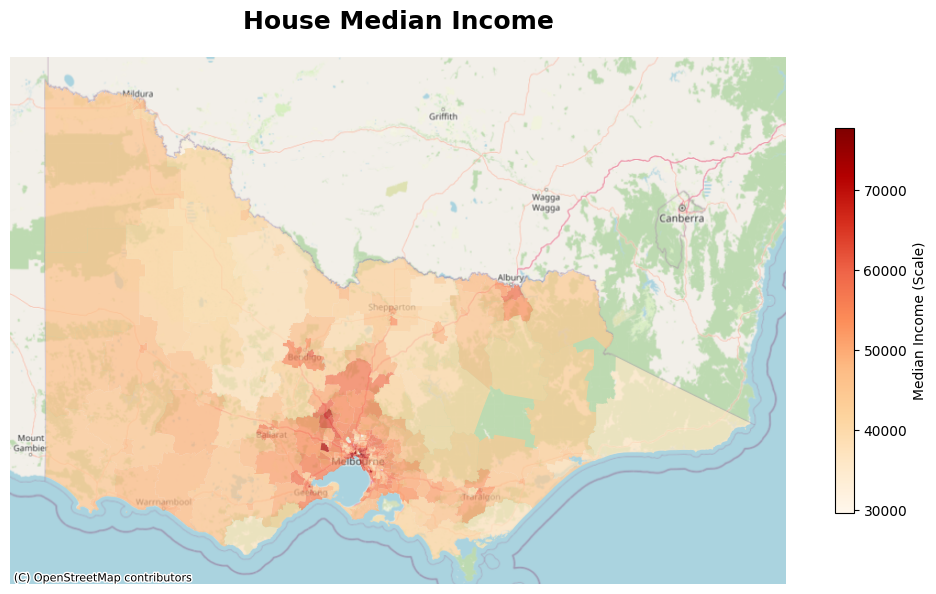

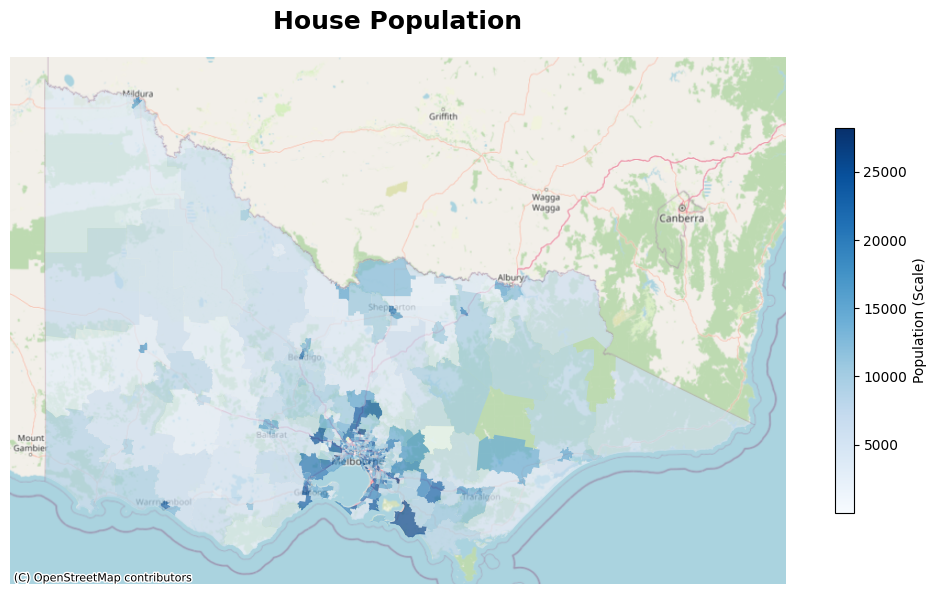

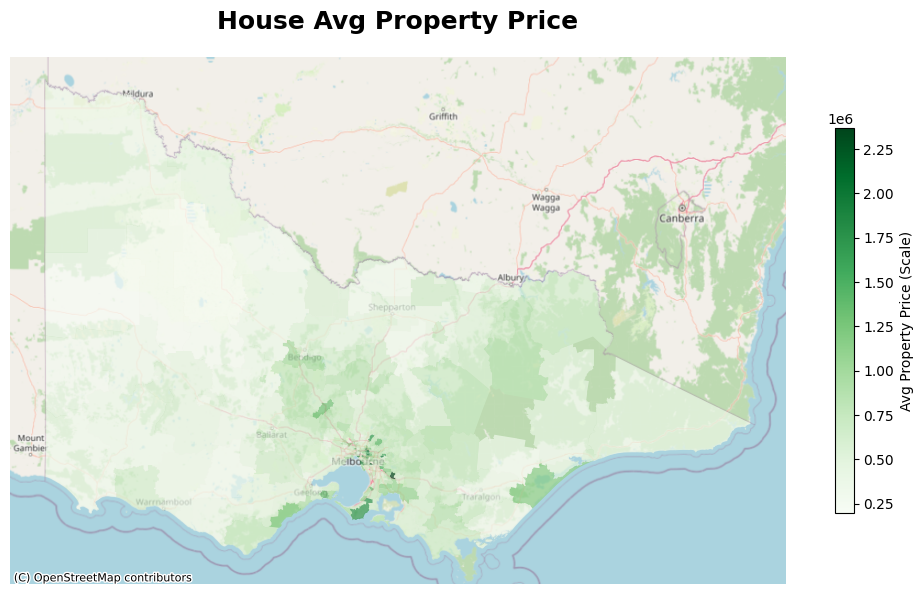

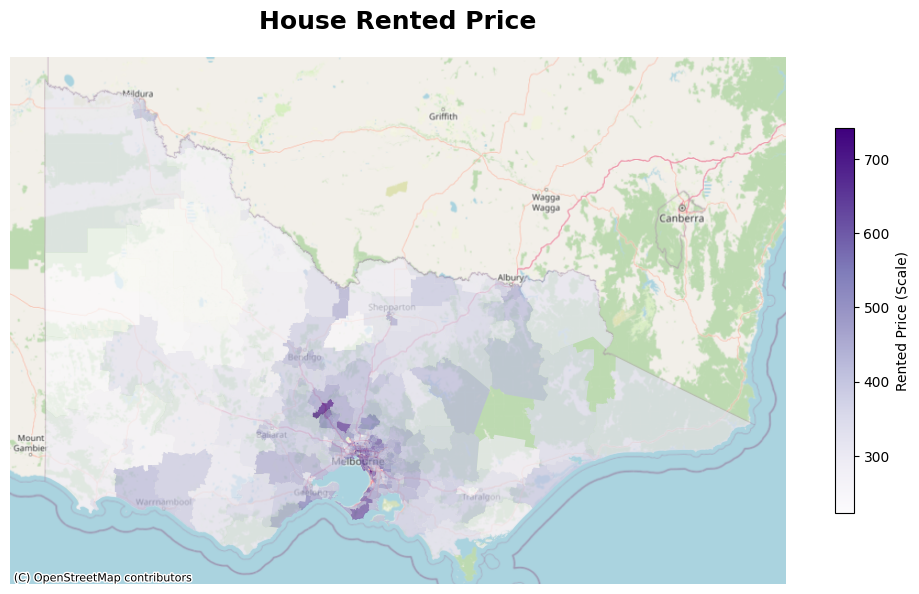

In [52]:
# Plot heatmaps for house data
house_agg_gdf = gpd.GeoDataFrame(house_agg_df, crs='EPSG:4326', geometry=house_agg_df['geometry'])
for column, cmap in columns_to_plot.items():
    plot_geospatial_heatmap_osm_save(house_agg_gdf, column, column.replace('_', ' ').title(), cmap, 'House')

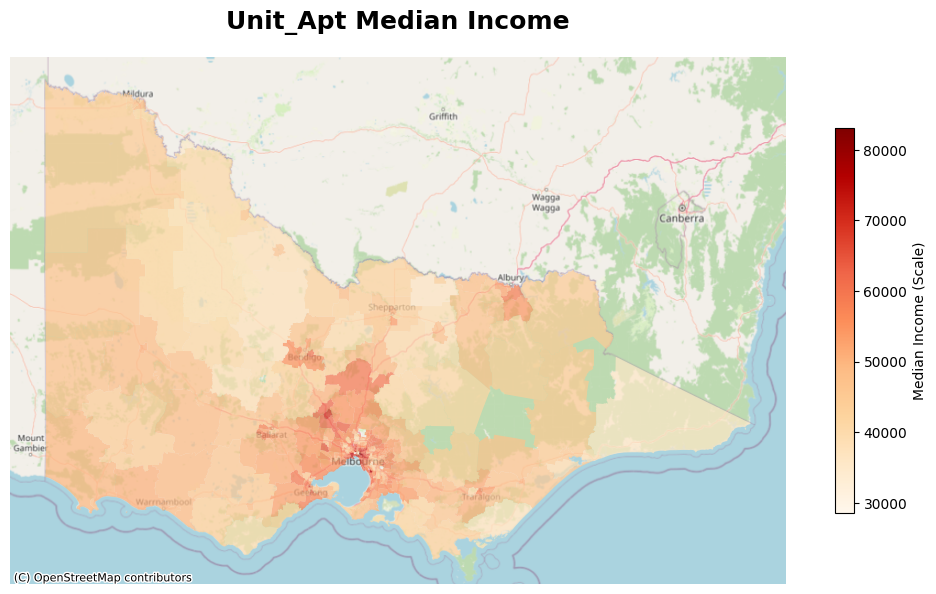

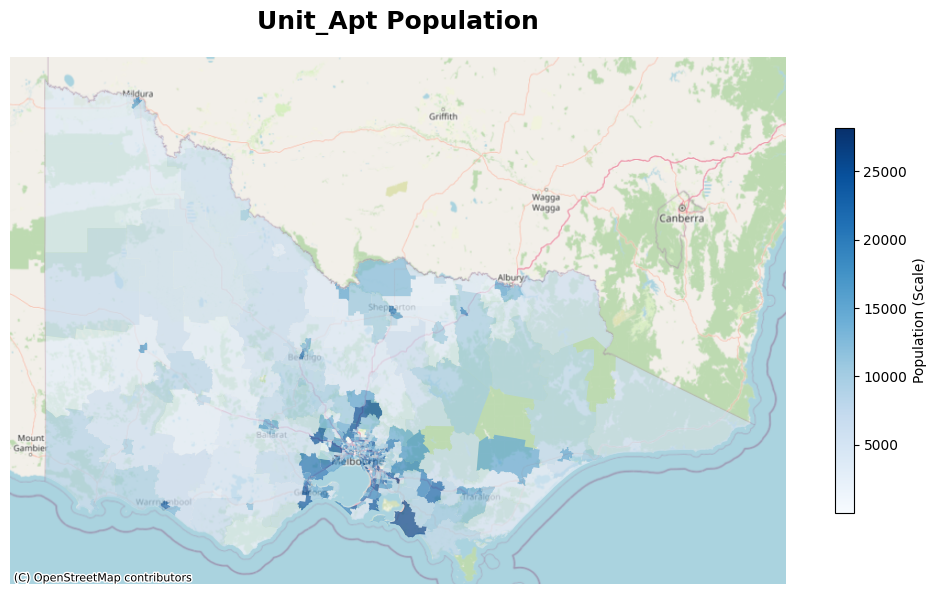

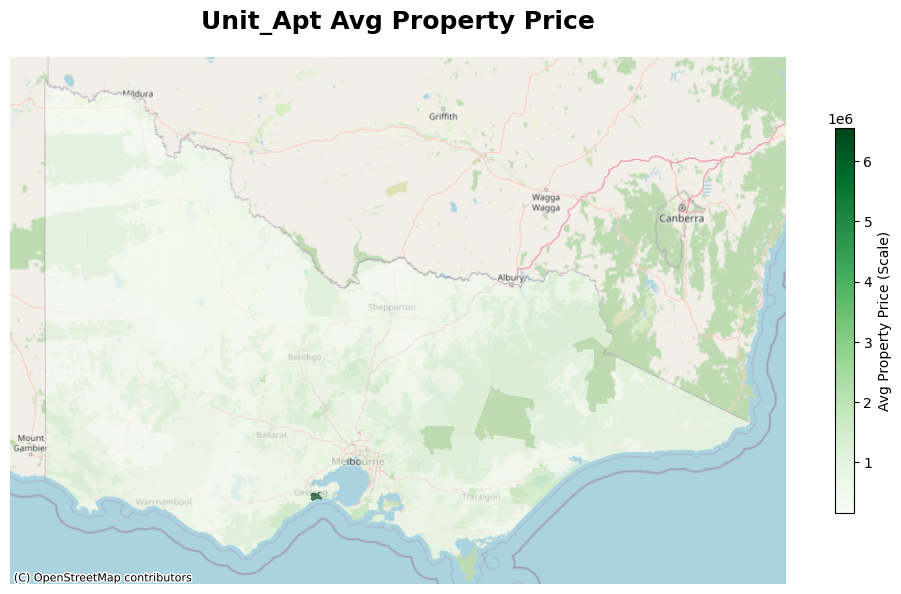

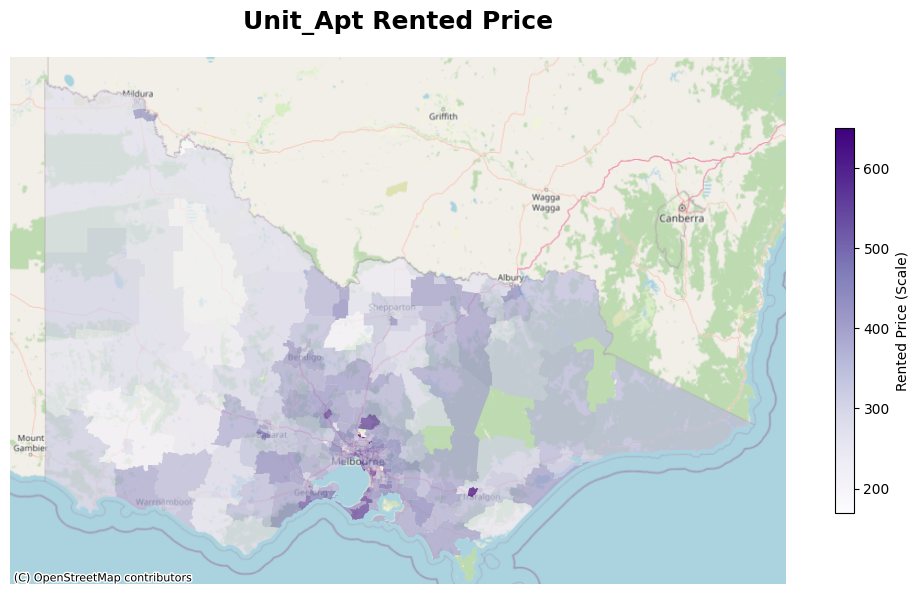

In [53]:
# Plot heatmaps for unit data
unit_agg_gdf = gpd.GeoDataFrame(unit_agg_df, crs='EPSG:4326', geometry=unit_agg_df['geometry'])
for column, cmap in columns_to_plot.items():
    plot_geospatial_heatmap_osm_save(unit_agg_gdf, column, column.replace('_', ' ').title(), cmap, 'Unit_Apt')